In [ ]:
import numpy as np
import pandas as pd
import os
import sys
sys.path.append(os.path.join(os.path.dirname(__file__), ".."))
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from toolkit_dslr.lr_utils import preprocess_data

In [2]:
class LogisticRegressionScratch:
    def __init__(self, learning_rate=0.01, iterations=1000):
        self.lr = learning_rate
        self.iterations = iterations
        self.weights = None
        self.bias = 0
        self.cost_history = []

    def sigmoid(self, z):
        """Sigmoid activation function"""
        return 1 / (1 + np.exp(-z))

    def cost(self, h, y):
        """Cross-entropy loss"""
        epsilon = 1e-5
        m = len(y)
        return - (1/m) * np.sum(y*np.log(h + epsilon) + (1-y)*np.log(1-h + epsilon))

    def fit(self, X, y):
        """Train model using gradient descent"""
        m, n = X.shape
        self.weights = np.zeros(n)

        for _ in range(self.iterations):
            h = self.sigmoid(np.dot(X, self.weights) + self.bias)

            dw = (1/m) * np.dot(X.T, (h - y))
            db = (1/m) * np.sum(h - y)

            self.weights -= self.lr * dw
            self.bias -= self.lr * db

            self.cost_history.append(self.cost(h, y))

        return self.weights, self.bias

    def predict(self, X):
        """Make predictions"""
        return self.sigmoid(np.dot(X, self.weights)
                             + self.bias)

    def predict_arguments(self, X, weights, bias):
        """Make predictions"""
        return self.sigmoid(np.dot(X, weights) + bias)

    def sgd(self, X, y, batch_size=1):
        m, n = X.shape
        self.weights = np.zeros(n) 
        self.cost_history = []

        for epoch in range(self.iterations):
            indices = np.random.permutation(m)
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            for i in range(0, m, batch_size):
                X_batch = X_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]

                h_batch = self.predict(X_batch)
                dw = (1/batch_size) * np.dot(X_batch.T, (h_batch - y_batch))
                db = (1/batch_size) * np.sum(h_batch - y_batch)

                self.weights -= self.lr * dw
                self.bias -= self.lr * db

            h_all = self.predict(X)
            cost = self.cost(h_all, y)
            self.cost_history.append(cost)

    def mini_batch_fit(self, X, y, batch_size=32):
        m, n = X.shape
        self.weights = np.zeros(n)
        self.cost_history = []

        for epoch in range(self.iterations):
            for i in range(0, m, batch_size):
                # Subset data for batches
                X_new = X[i:i+batch_size]
                y_new = y[i:i+batch_size]

                y_pred = self.predict(X_new)

                # Update weights and bias
                dw = (1/batch_size) * np.dot(X_new.T, (y_pred - y_new))
                db = (1/batch_size) * np.sum(y_pred - y_new)

                self.weights -= self.lr * dw
                self.bias -= self.lr * db

            h_all = self.predict(X)
            cost = self.cost(h_all, y)
            self.cost_history.append(cost)


In [3]:
def LogisticRegression(file: str):
    df = pd.read_csv(file)
    imputer = SimpleImputer(strategy="mean")

    houses = ["Gryffindor", "Slytherin", "Ravenclaw", "Hufflepuff"]
    X = preprocess_data(df)

    X_train, X_test, y_train_global, y_test_global = train_test_split(
        X, df["Hogwarts House"].values, test_size=0.2, random_state=42
    )

    models = {}
    for house in houses:
        y_train = np.array([1 if i == house else 0 for i in y_train_global])

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        model = LogisticRegressionScratch(learning_rate=0.1, iterations=1000)
        model.fit(X_train, y_train)

        plt.plot(model.cost_history)
        plt.title("Cost Function Convergence")
        plt.xlabel("Iterations")
        plt.ylabel("Cost")
        plt.grid(True)
        plt.show()
        models[house] = (model, scaler)


    house_preds = []
    for idx in range(X_test.shape[0]):
        probas = []
        for house in houses:
            model, scaler = models[house]
            x = X_test[idx].reshape(1, -1)
            proba = model.predict(x)[0]
            probas.append(proba)
        best_house_idx = np.argmax(probas)
        house_preds.append(houses[best_house_idx])

    accuracy = np.mean(house_preds == y_test_global)
    print(f"Model Accuracy: {accuracy:.2f}")

In [81]:
def LogisticRegression(file: str):
    df = pd.read_csv(file)
    imputer = SimpleImputer(strategy="mean")

    houses = ["Gryffindor", "Slytherin", "Ravenclaw", "Hufflepuff"]
    X = preprocess_data(df)

    X_train, X_test, y_train_global, y_test_global = train_test_split(
        X, df["Hogwarts House"].values, test_size=0.2, random_state=42
    )

    models = {}
    for house in houses:
        y_train = np.array([1 if i == house else 0 for i in y_train_global])

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        model = LogisticRegressionScratch(learning_rate=0.1, iterations=1000)

        # Using Stochastic gradient descent with batch size of 1
        model.sgd(X_train, y_train)

        plt.plot(model.cost_history)
        plt.title("Cost Function Convergence")
        plt.xlabel("Iterations")
        plt.ylabel("Cost")
        plt.grid(True)
        plt.show()
        models[house] = (model, scaler)


    house_preds = []
    for idx in range(X_test.shape[0]):
        probas = []
        for house in houses:
            model, scaler = models[house]
            x = X_test[idx].reshape(1, -1)
            proba = model.predict(x)[0]
            probas.append(proba)
        best_house_idx = np.argmax(probas)
        house_preds.append(houses[best_house_idx])

    accuracy = np.mean(house_preds == y_test_global)
    print(f"Model Accuracy: {accuracy:.2f}")

In [51]:
def LogisticRegression(file: str):
    df = pd.read_csv(file)
    imputer = SimpleImputer(strategy="mean")

    houses = ["Gryffindor", "Slytherin", "Ravenclaw", "Hufflepuff"]
    X = preprocess_data(df)

    X_train, X_test, y_train_global, y_test_global = train_test_split(
        X, df["Hogwarts House"].values, test_size=0.2, random_state=42
    )

    models = {}
    for house in houses:
        y_train = np.array([1 if i == house else 0 for i in y_train_global])

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        model = LogisticRegressionScratch(learning_rate=0.1, iterations=1000)
        
        # Using mini-batch gradient descent with batch size of 32
        model.mini_batch_fit(X_train, y_train, batch_size=32)

        plt.plot(model.cost_history)
        plt.title("Cost Function Convergence")
        plt.xlabel("Iterations")
        plt.ylabel("Cost")
        plt.grid(True)
        plt.show()
        models[house] = (model, scaler)


    house_preds = []
    for idx in range(X_test.shape[0]):
        probas = []
        for house in houses:
            model, scaler = models[house]
            x = X_test[idx].reshape(1, -1)
            proba = model.predict(x)[0]
            probas.append(proba)
        best_house_idx = np.argmax(probas)
        house_preds.append(houses[best_house_idx])

    accuracy = np.mean(house_preds == y_test_global)
    print(f"Model Accuracy: {accuracy:.2f}")

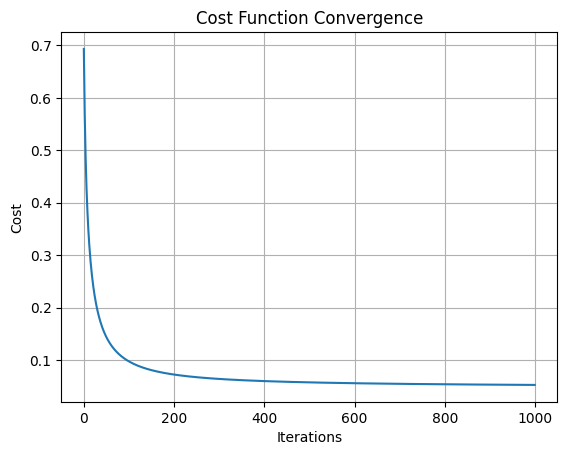

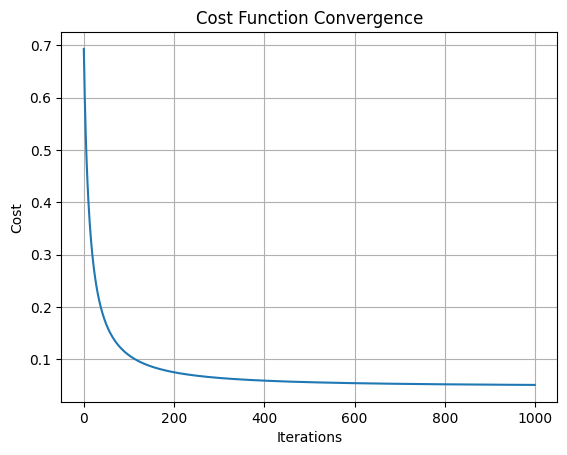

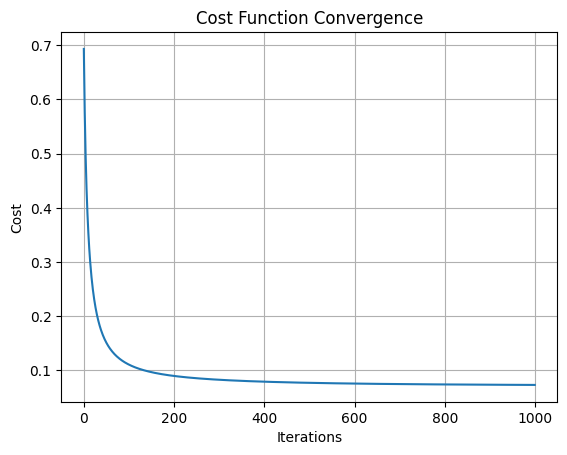

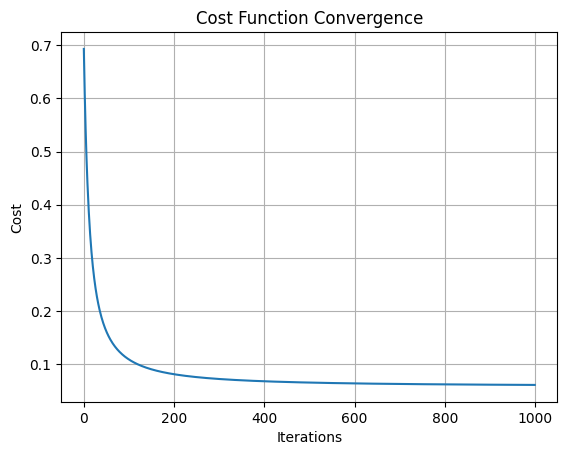

Model Accuracy: 0.99


In [4]:
LogisticRegression("datasets/dataset_train.csv")